# PIYASA DEGER TAHMIN ALGORITMASI 

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, FloatType
from pyspark.sql.functions import split, count, when, isnan, col, regexp_replace
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from handyspark import *
import warnings
warnings.filterwarnings('ignore')
from pyspark.ml.feature import VectorAssembler
from sklearn.model_selection import train_test_split
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import RandomForestRegressor

In [2]:
spark = SparkSession.builder.appName('Project Session').getOrCreate()

In [3]:
file_path = 'soccer_player.csv'

df = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')

df.toPandas()

,Team,League,player,Substitution,xG Per Avg Match,Shots,OnTarget,Shots Per Avg Match,On Target Per Avg Match,value,...,goals,goals_per_shot,passes_completed,assisted_shots,passes_blocked,touches,height,assists,games_starts,minutes
0,0,MLS,Robert Beric,1,0.46,62,28,2.86,1.29,2400000,...,1,0.14,46,3,5,115,188,0,4,413
1,1,La Liga,Karim Benzema,0,0.63,27,12,3.46,1.54,32000000,...,21,0.14,1119,61,36,1688,184,8,36,3141
2,2,La Liga,Carlos Soler,1,0.53,8,5,1.27,0.79,40000000,...,2,0.11,582,12,26,932,180,0,24,2066
3,3,La Liga,Cristian Tello,4,0.29,22,8,3.32,1.21,4000000,...,2,0.11,285,7,16,453,178,0,5,787
4,4,La Liga,Mikel Oyarzabal,2,0.88,31,16,4.00,2.07,48000000,...,10,0.11,828,53,88,1571,181,11,36,3051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,75,Premier League,Jamie Vardy,1,1.06,21,15,2.56,1.83,16000000,...,23,0.22,314,28,28,734,179,5,34,3033
76,76,Premier League,Harry Kane,0,0.66,39,15,3.88,1.49,120000000,...,18,0.21,394,24,33,923,188,2,29,2587
77,77,Premier League,Neal Maupay,0,0.79,25,11,3.02,1.33,17000000,...,10,0.10,540,26,33,1063,173,3,30,2766
78,78,Premier League,Sadio Mane,1,0.59,27,13,3.27,1.57,120000000,...,18,0.24,933,56,50,1590,174,7,31,2747


In [4]:
df.printSchema()

root
 |-- Team: integer (nullable = true)
 |-- League: string (nullable = true)
 |-- player: string (nullable = true)
 |-- Substitution: integer (nullable = true)
 |-- xG Per Avg Match: double (nullable = true)
 |-- Shots: integer (nullable = true)
 |-- OnTarget: integer (nullable = true)
 |-- Shots Per Avg Match: double (nullable = true)
 |-- On Target Per Avg Match: double (nullable = true)
 |-- value: integer (nullable = true)
 |-- nationality: string (nullable = true)
 |-- position: string (nullable = true)
 |-- squad: string (nullable = true)
 |-- goals: integer (nullable = true)
 |-- goals_per_shot: double (nullable = true)
 |-- passes_completed: integer (nullable = true)
 |-- assisted_shots: integer (nullable = true)
 |-- passes_blocked: integer (nullable = true)
 |-- touches: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- assists: integer (nullable = true)
 |-- games_starts: integer (nullable = true)
 |-- minutes: integer (nullable = true)



In [5]:
df.select('squad','League').collect()

[Row(squad='Saint-�?�?�tienne', League='MLS'),
 Row(squad='Real Madrid', League='La Liga'),
 Row(squad='Valencia', League='La Liga'),
 Row(squad='Betis', League='La Liga'),
 Row(squad='Real Sociedad', League='La Liga'),
 Row(squad='Eibar', League='La Liga'),
 Row(squad='Alav�???s', League='La Liga'),
 Row(squad='Barcelona', League='La Liga'),
 Row(squad='Real Madrid', League='La Liga'),
 Row(squad='Barcelona', League='La Liga'),
 Row(squad='Celta Vigo', League='La Liga'),
 Row(squad='Barcelona', League='La Liga'),
 Row(squad='Villarreal', League='La Liga'),
 Row(squad='Bologna', League='Serie A'),
 Row(squad='Sassuolo', League='Serie A'),
 Row(squad='Torino', League='Serie A'),
 Row(squad='Fiorentina', League='Serie A'),
 Row(squad='Cagliari', League='Serie A'),
 Row(squad='Sassuolo', League='Serie A'),
 Row(squad='Arsenal', League='Serie A'),
 Row(squad='Roma', League='Serie A'),
 Row(squad='Roma', League='Serie A'),
 Row(squad='Atalanta', League='Serie A'),
 Row(squad='Juventus', Lea

Veri icerisinde hatali takim-lig eslesmeleri bulunmaktadir (Orn: squad='Crystal Palace', League='Ligue 1'). Bu durum dogru takim-lig degerlerini tutan lig_takim verisi ile gerceklestirilecek join islemi ile duzeltilecektir

In [6]:
file_path = 'lig_takim.csv'

df2 = spark.read.csv(file_path,
                    header = True,
                    inferSchema = True,
                    nanValue = '?')
df2.show(5)

+---------------+-------+
|          squad| League|
+---------------+-------+
|         Alav�s|La Liga|
|Athletic Bilbao|La Liga|
|Atl�tico Madrid|La Liga|
|      Barcelona|La Liga|
|     Celta Vigo|La Liga|
+---------------+-------+
only showing top 5 rows



Proje Avrupa'nin bes buyuk ligine odaklandigindan bu liglerden biri olmayan MLS ligine ait sutun veri setinden atilir

In [7]:
df = df.drop(df.League=="MLS")

Join isleminden once df icerisinde hatali degerler iceren League column'u ve sadece satir sayisini iceren, daha sonrasinda kesinlikle kullanilmayacak olan Team column'u droplanir

In [8]:
df = df.drop(("League"))
df = df.drop(("Team"))

JOIN

In [9]:
data_frame = df.join(df2, df['squad'] == df2['squad'])
#drop duplicate column
data_frame = df.join(df2,['squad'])
data_frame.toPandas()

,squad,player,Substitution,xG Per Avg Match,Shots,OnTarget,Shots Per Avg Match,On Target Per Avg Match,value,nationality,...,goals_per_shot,passes_completed,assisted_shots,passes_blocked,touches,height,assists,games_starts,minutes,League
0,Real Madrid,Karim Benzema,0,0.63,27,12,3.46,1.54,32000000,fr FRA,...,0.14,1119,61,36,1688,184,8,36,3141,La Liga
1,Valencia,Carlos Soler,1,0.53,8,5,1.27,0.79,40000000,es ESP,...,0.11,582,12,26,932,180,0,24,2066,La Liga
2,Real Sociedad,Mikel Oyarzabal,2,0.88,31,16,4.00,2.07,48000000,es ESP,...,0.11,828,53,88,1571,181,11,36,3051,La Liga
3,Eibar,Esteban Burgos,1,0.46,5,4,0.81,0.65,72500,ar ARG,...,0.50,244,1,3,515,191,0,11,1119,La Liga
4,Barcelona,Lionel Messi,1,0.63,39,19,4.50,2.19,112000000,ar ARG,...,0.13,1700,86,62,2614,170,21,32,2880,La Liga
5,Real Madrid,Federico Valverde,2,0.19,9,5,1.51,0.84,54000000,uy URU,...,0.09,985,19,18,1316,182,5,21,1907,La Liga
6,Barcelona,Antoine Griezmann,1,0.55,18,8,2.70,1.20,96000000,fr FRA,...,0.16,935,33,49,1408,176,4,31,2549,La Liga
7,Celta Vigo,Iago Aspas,0,0.44,21,12,1.89,1.08,16000000,es ESP,...,0.12,998,54,63,1676,176,3,37,3262,La Liga
8,Barcelona,Ansu Fati,1,0.38,14,7,2.95,1.47,80000000,es ESP,...,0.21,446,17,13,724,178,1,11,1027,La Liga
9,Villarreal,Gerard Moreno,0,0.74,29,11,3.35,1.27,16000000,es ESP,...,0.20,743,50,48,1447,180,5,33,2744,La Liga


## EDA

In [10]:
#Eksik veri tespiti
print('Eksik Veriler')
for column in data_frame.columns:
    print(column ,':', df.filter(col(column).isin(np.nan) 
              | col(column).isNull()).count())

Eksik Veriler
squad : 0
player : 0
Substitution : 0
xG Per Avg Match : 0
Shots : 0
OnTarget : 0
Shots Per Avg Match : 0
On Target Per Avg Match : 0
value : 0
nationality : 0
position : 0
goals : 0
goals_per_shot : 0
passes_completed : 0
assisted_shots : 0
passes_blocked : 0
touches : 0
height : 0
assists : 0
games_starts : 0
minutes : 0
League : 0


Veri Setinde eksik veri bulunmamaktadir

In [11]:
#Veri setinde en cok oyunucusu bulunan lig
frequent_league = data_frame.select(data_frame.League, data_frame.player) \
                            .groupBy(data_frame.League) \
                            .count() \
                            .orderBy("count", ascending=False).collect()[0]
print('Veri setinde en cok oyunucusu bulunan Lig: ')
frequent_league

Veri setinde en cok oyunucusu bulunan Lig: 


Row(League='Serie A', count=16)

In [12]:
#Veri Setinde birden fazla kez var olan oyuncular
player_count = data_frame.select(data_frame.player) \
                            .groupBy(data_frame.player) \
                            .count() \
                            .orderBy("count", ascending=False)
player_count_not_unique = player_count.select(player_count['player'],player_count['count']) \
            .filter(player_count['count'] > 1)
print('players with count > 1:')
player_count_not_unique.show()

players with count > 1:
+------------------+-----+
|            player|count|
+------------------+-----+
|Henrikh Mkhitaryan|    2|
|     Matheus Cunha|    2|
+------------------+-----+



In [13]:
#Satir tekrari mi var oyuncu ayni sezonda iki farkli kulupte mi oynadi
henrikh_mkhitaryan = data_frame.select(data_frame.squad).filter(data_frame.player == 'Henrikh Mkhitaryan')
henrikh_mkhitaryan.show()

+-------+
|  squad|
+-------+
|Arsenal|
|   Roma|
+-------+



In [14]:
matheus_cunha = data_frame.select(data_frame.squad).filter(data_frame.player == 'Matheus Cunha')
matheus_cunha.show()

+----------+
|     squad|
+----------+
|Hertha BSC|
|RB Leipzig|
+----------+



Oyuncular ayni sezonda iki farkli kulupte oynadigi icin iki kere ismi gecmesi veriden kaynakli bir hata degildir

In [15]:
#Tekrar eden sutun varsa veri setinden tekrari atilir
data_frame = data_frame.dropDuplicates()

Mantiksal hatalar tespit edilmeye calisilir

In [16]:
#Sut sayisi gol sayisindan fazla olan oyuncu/oyuncular var mi
hata = data_frame.select(data_frame.squad ,data_frame.player ,data_frame.Shots , data_frame.goals) \
                 .filter( ~(data_frame.Shots >= data_frame.goals))
hata.show()

+--------------+-----------------+-----+-----+
|         squad|           player|Shots|goals|
+--------------+-----------------+-----+-----+
|Leicester City|      Jamie Vardy|   21|   23|
|         Lazio|    Ciro Immobile|   22|   36|
|      Juventus|Cristiano Ronaldo|   26|   31|
|    RB Leipzig|      Timo Werner|   23|   28|
|      Sassuolo| Francesco Caputo|   18|   21|
+--------------+-----------------+-----+-----+



In [17]:
#hatali degerler silinir
data_frame = data_frame.filter(data_frame.Shots >= data_frame.goals)

In [18]:
hata = data_frame.select(data_frame.squad ,data_frame.player ,data_frame.passes_completed , data_frame.assists) \
                 .filter( ~(data_frame.passes_completed >= data_frame.assists))
hata.show()

+-----+------+----------------+-------+
|squad|player|passes_completed|assists|
+-----+------+----------------+-------+
+-----+------+----------------+-------+



Hatali degerler basarili sekilde silinmistir

In [19]:
#Sut sayisi hedefi bulan sut sayisindan fazla olan oyuncu/oyuncular var mi
hata = data_frame.select(data_frame.player ,data_frame.Shots , data_frame.OnTarget) \
                 .filter( ~(data_frame.Shots >= data_frame.OnTarget))
hata.show()

+------+-----+--------+
|player|Shots|OnTarget|
+------+-----+--------+
+------+-----+--------+



Bu noktada herhangi bir hata yok

### Ozniteliklerin Detayli Incelenmesi

In [20]:
data_frame.toPandas().shape

(55, 22)

In [21]:
hdf = data_frame.toHandy()

squad

In [22]:
data_frame.select('squad').distinct().count()

43

Cok fazla distinct deger olmasi nedeni ile model egitimine bulunacagi katkidan oturu oznitelik veri setinden atilir

In [23]:
data_frame = data_frame.drop('squad')

Player

In [24]:
data_frame.select('player').distinct().count()

53

Cok fazla distinct deger olmasi nedeni ile model egitimine bulunacagi katkidan oturu oznitelik veri setinden atilir

In [25]:
data_frame = data_frame.drop('player')

Substitution

In [26]:
data_frame.select('Substitution').distinct().count()

6

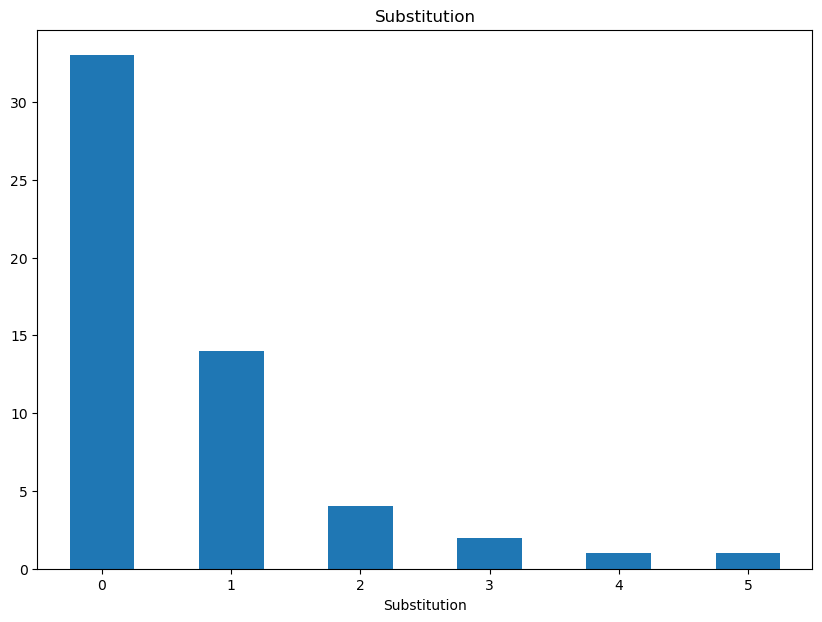

In [27]:
fig, ax = plt.subplots(figsize=(10, 7))
hdf.cols['Substitution'].hist(ax=ax)
plt.show()

In [28]:
data_frame.select('Substitution').describe().show()

+-------+------------------+
|summary|      Substitution|
+-------+------------------+
|  count|                55|
|   mean|0.6727272727272727|
| stddev| 1.089589549878938|
|    min|                 0|
|    max|                 5|
+-------+------------------+



Shots

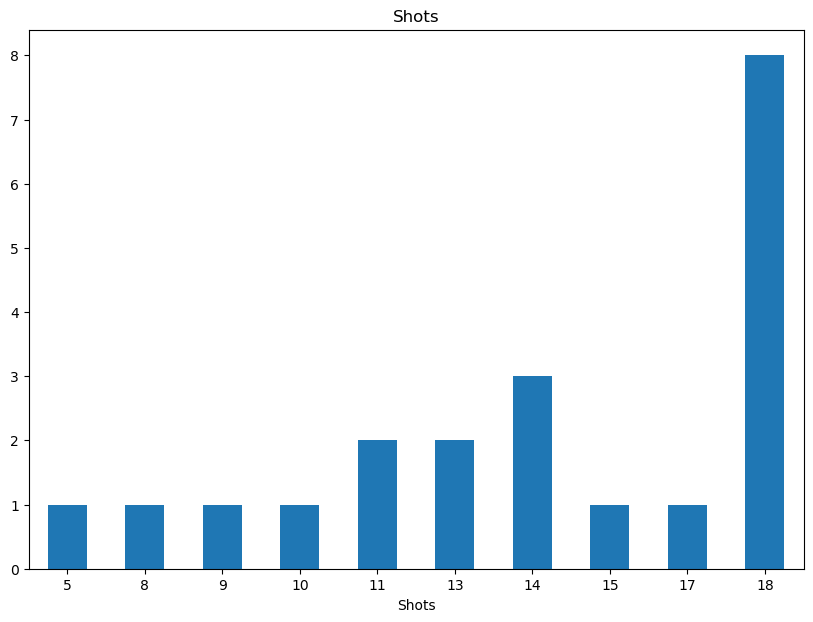

In [29]:
fig, ax = plt.subplots(figsize=(10, 7))
hdf.cols['Shots'].hist(ax=ax)
plt.show()

In [30]:
data_frame.select('Shots').describe().show()

+-------+------------------+
|summary|             Shots|
+-------+------------------+
|  count|                55|
|   mean|21.963636363636365|
| stddev|7.8809748324534254|
|    min|                 5|
|    max|                39|
+-------+------------------+



OnTarget

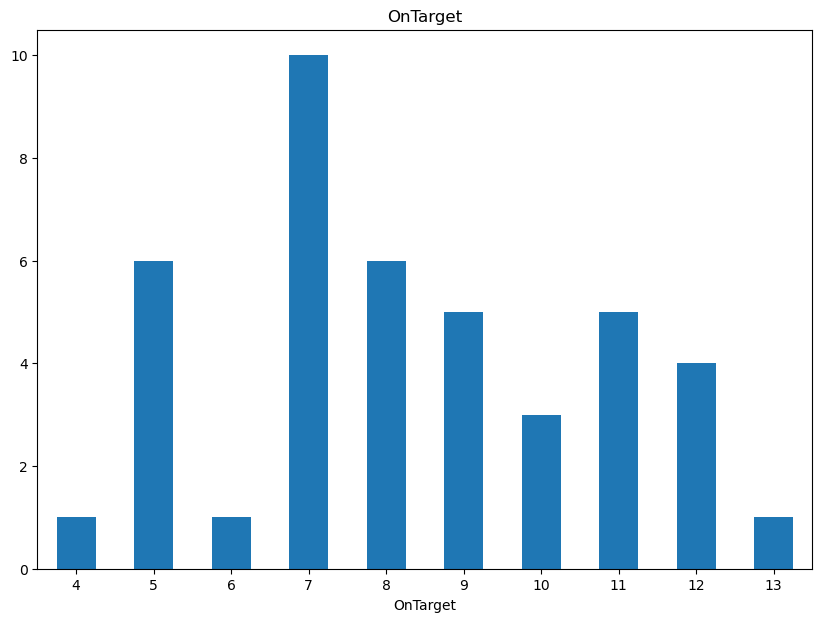

In [31]:
fig, ax = plt.subplots(figsize=(10, 7))
hdf.cols['OnTarget'].hist(ax=ax)
plt.show()

In [32]:
data_frame.select('OnTarget').describe().show()

+-------+------------------+
|summary|          OnTarget|
+-------+------------------+
|  count|                55|
|   mean|10.036363636363637|
| stddev| 3.829532590972411|
|    min|                 4|
|    max|                19|
+-------+------------------+



value

In [33]:
data_frame.select('value').describe().show()

+-------+--------------------+
|summary|               value|
+-------+--------------------+
|  count|                  55|
|   mean| 2.822859090909091E7|
| stddev|2.9707936742575075E7|
|    min|               72500|
|    max|           120000000|
+-------+--------------------+



In [34]:
#modelin ogrenmesinde value degerleri cok yuksek oldugu icin sikinti yasanmasindan oturu degerler guncellenmistir
data_frame=data_frame.withColumn("value", df.value/10000)
data_frame.select('value').describe().show()

+-------+------------------+
|summary|             value|
+-------+------------------+
|  count|                55|
|   mean| 2822.859090909091|
| stddev|2970.7936742575066|
|    min|              7.25|
|    max|           12000.0|
+-------+------------------+



nationality

In [35]:
data_frame.select('nationality').distinct().count()

23

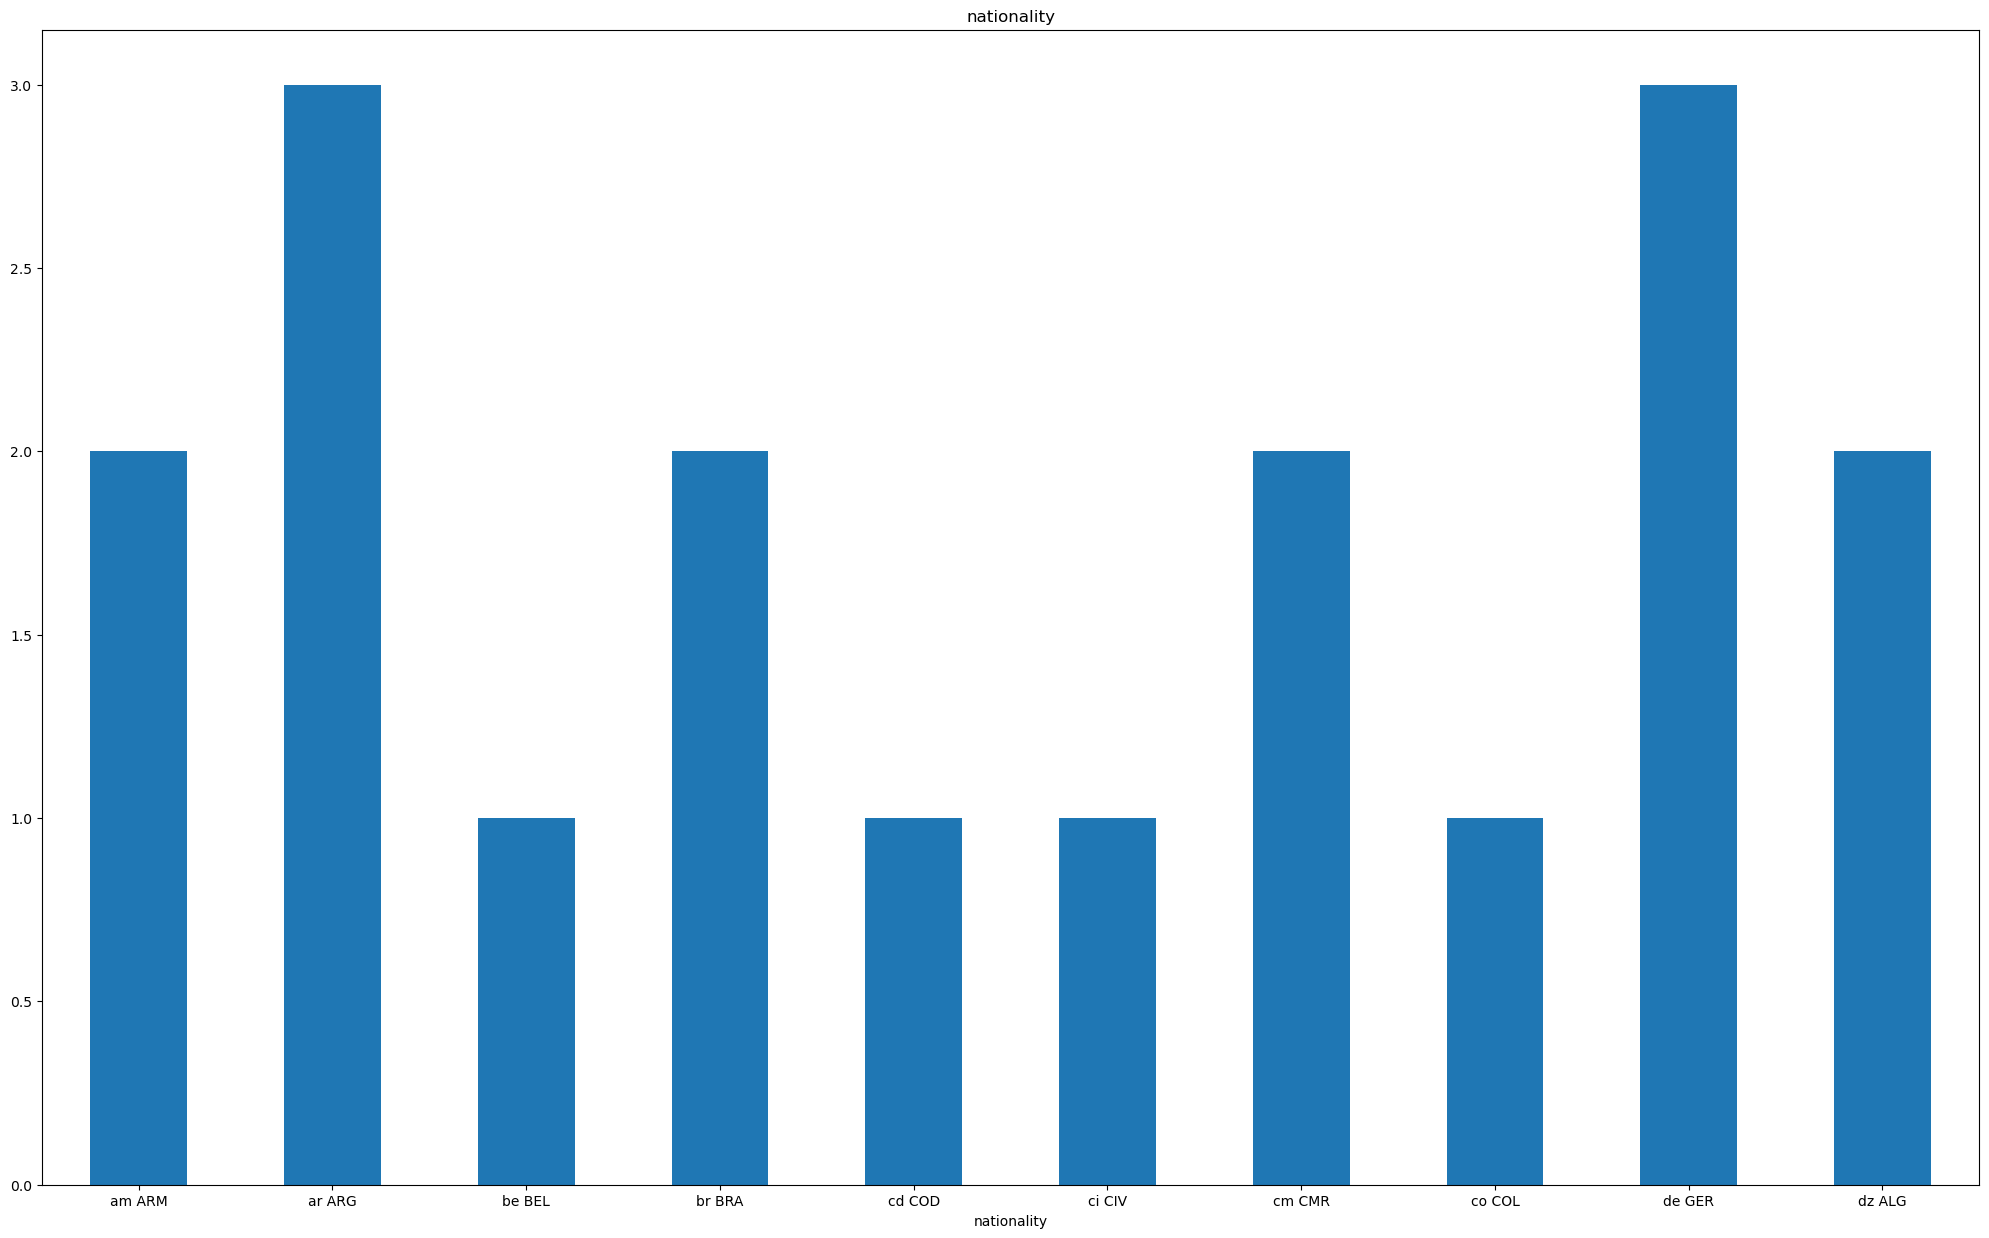

In [36]:
fig, ax = plt.subplots(figsize=(25, 15))
hdf.cols['nationality'].hist(ax=ax)
plt.show()

Model egitimi icin veri setindeki sayisal olmayan degerler sayisallastirilmali

In [37]:
nationality_indexer = StringIndexer(inputCol='nationality', outputCol='nationalityIndex')
data_frame = nationality_indexer.fit(data_frame).transform(data_frame)

In [38]:
data_frame.select('nationality','nationalityIndex').distinct().show()

+-----------+----------------+
|nationality|nationalityIndex|
+-----------+----------------+
|     cm CMR|             9.0|
|     it ITA|             1.0|
|     sn SEN|             6.0|
|     cd COD|            12.0|
|     mx MEX|            16.0|
|     uy URU|            22.0|
|     de GER|             5.0|
|     re REU|            20.0|
|     ci CIV|            13.0|
|    eng ENG|             3.0|
|     dz ALG|            10.0|
|     pt POR|            19.0|
|     se SWE|            21.0|
|     ar ARG|             4.0|
|     br BRA|             8.0|
|     fr FRA|             0.0|
|     nl NED|            17.0|
|     am ARM|             7.0|
|     es ESP|             2.0|
|     eg EGY|            15.0|
+-----------+----------------+
only showing top 20 rows



In [39]:
data_frame = data_frame.drop('nationality')

Position

In [40]:
data_frame.select('position').distinct().count()

7

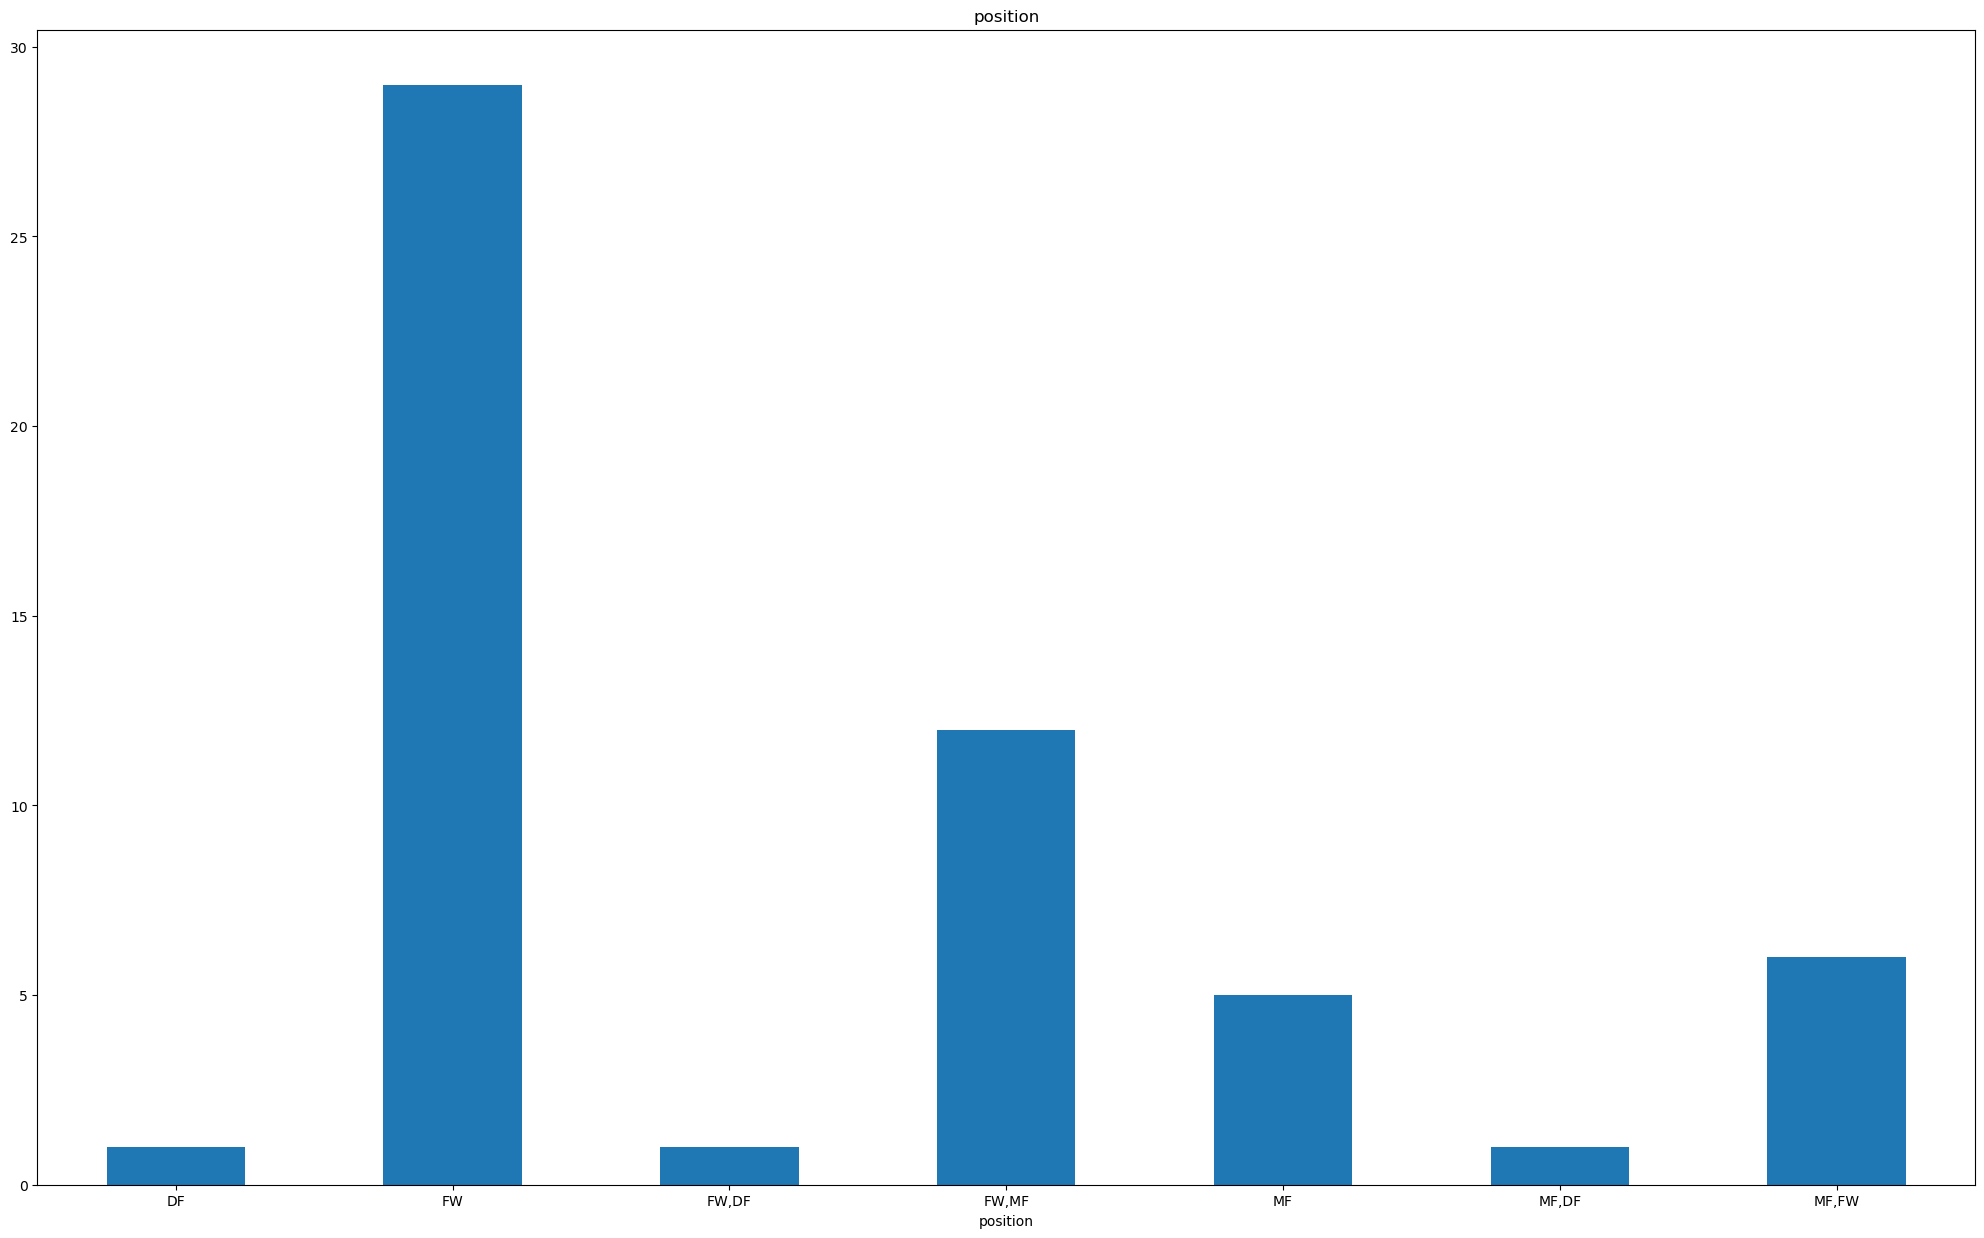

In [41]:
fig, ax = plt.subplots(figsize=(25, 15))
hdf.cols['position'].hist(ax=ax)
plt.show()

In [42]:
position_indexer = StringIndexer(inputCol='position', outputCol='positionIndex')
data_frame = position_indexer.fit(data_frame).transform(data_frame)

In [43]:
data_frame.select('position','positionIndex').distinct().show()

+--------+-------------+
|position|positionIndex|
+--------+-------------+
|   FW,MF|          1.0|
|      DF|          4.0|
|   MF,DF|          6.0|
|   FW,DF|          5.0|
|      MF|          3.0|
|      FW|          0.0|
|   MF,FW|          2.0|
+--------+-------------+



In [44]:
data_frame = data_frame.drop('position')

League

In [45]:
data_frame.select('League').distinct().count()

5

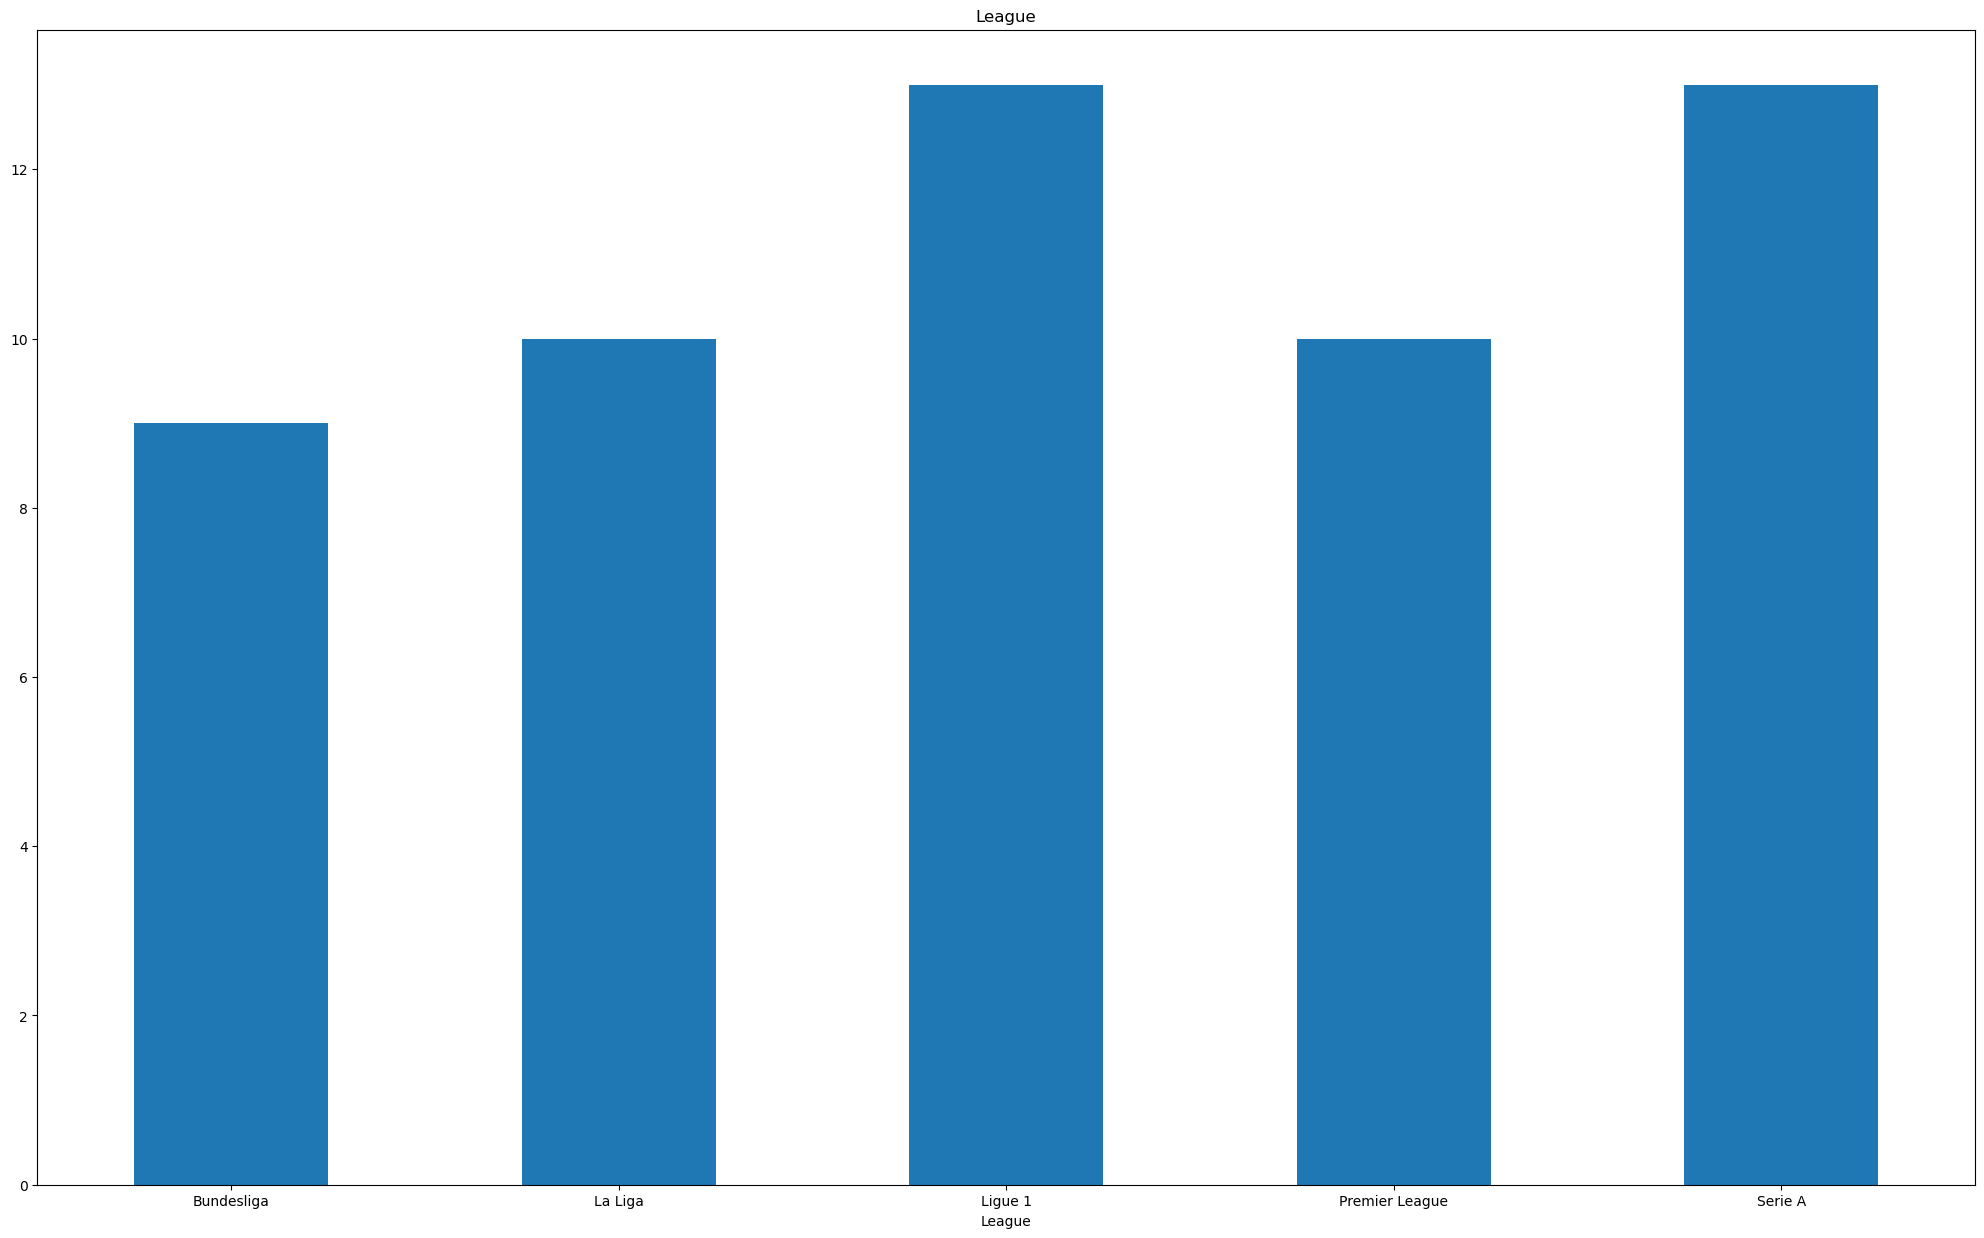

In [46]:
fig, ax = plt.subplots(figsize=(25, 15))
hdf.cols['League'].hist(ax=ax)
plt.show()

In [47]:
league_indexer = StringIndexer(inputCol='League', outputCol='LeagueIndex')
data_frame = league_indexer.fit(data_frame).transform(data_frame)

In [48]:
data_frame.select('League','LeagueIndex').distinct().show()

+--------------+-----------+
|        League|LeagueIndex|
+--------------+-----------+
|Premier League|        3.0|
|    Bundesliga|        4.0|
|       La Liga|        2.0|
|       Serie A|        1.0|
|       Ligue 1|        0.0|
+--------------+-----------+



In [49]:
data_frame = data_frame.drop('League')

#### Gorsellestirme

In [50]:
df_pandas = data_frame.toPandas()

<AxesSubplot:title={'center':'Goals - Value'}, xlabel='goals', ylabel='value'>

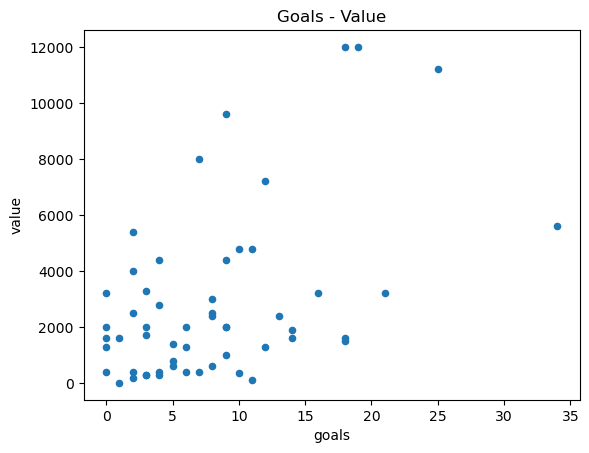

In [51]:
df_pandas.plot.scatter(x='goals', y='value', title= 'Goals - Value')

<AxesSubplot:title={'center':'Assists - Value'}, xlabel='assists', ylabel='value'>

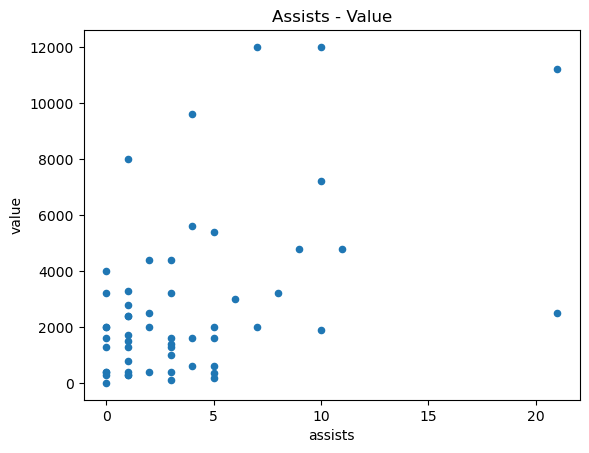

In [52]:
df_pandas.plot.scatter(x='assists', y='value', title= 'Assists - Value')

<AxesSubplot:title={'center':'Touches - Value'}, xlabel='touches', ylabel='value'>

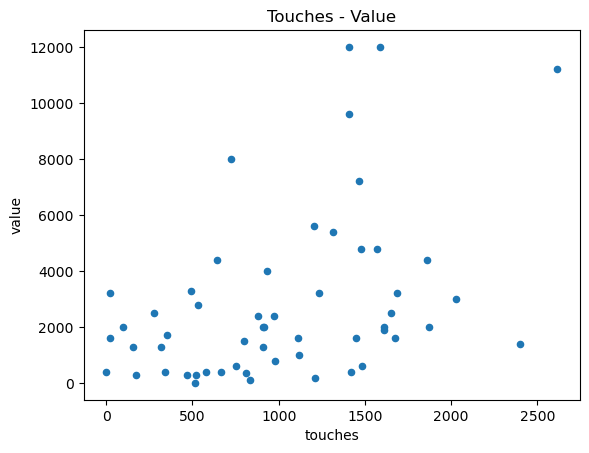

In [53]:
df_pandas.plot.scatter(x='touches', y='value', title= 'Touches - Value')

<AxesSubplot:title={'center':'Height - Value'}, xlabel='height', ylabel='value'>

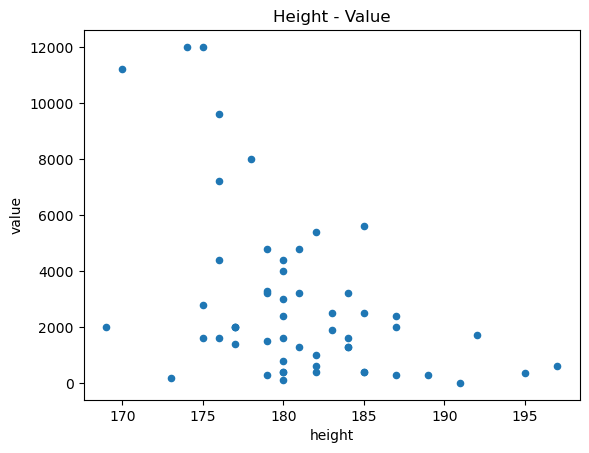

In [54]:
df_pandas.plot.scatter(x='height', y='value', title= 'Height - Value')

<AxesSubplot:title={'center':'Games_starts - Value'}, xlabel='games_starts', ylabel='value'>

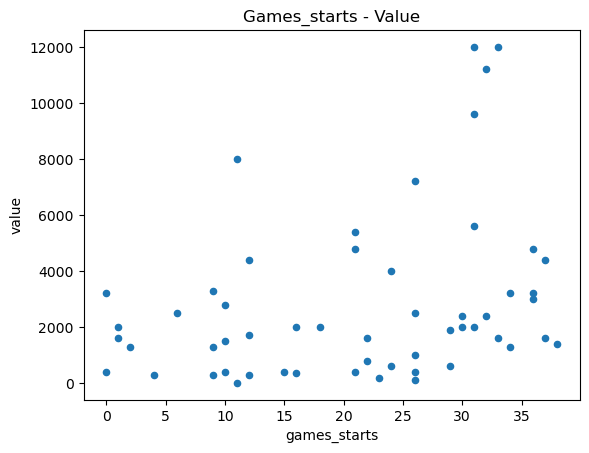

In [55]:
df_pandas.plot.scatter(x='games_starts', y='value', title= 'Games_starts - Value')

###### Correlation Matrix

<AxesSubplot:>

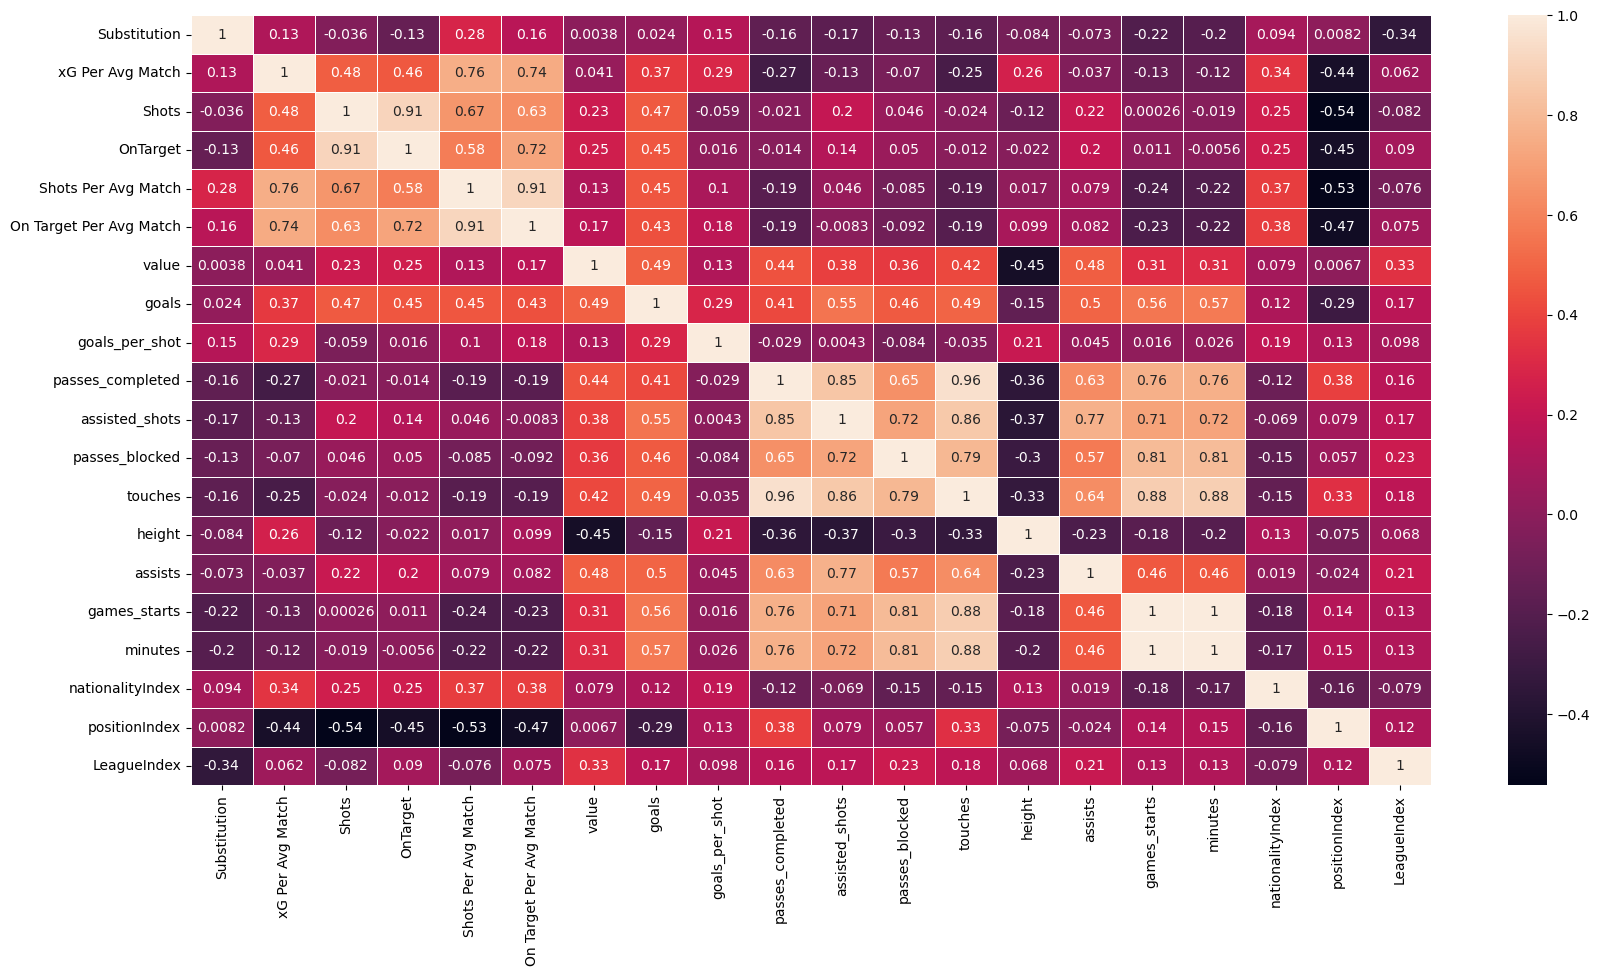

In [56]:
import seaborn as sns
corr = df_pandas.corr()
f, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr, annot=True, linewidths=.5, ax=ax)

### Model Egitimi ve Tahmin

Model egitimi icin butun oznitelikleri barindiran bir vector yaratilir

In [57]:
assembler = VectorAssembler(inputCols=data_frame.drop('value').columns, outputCol="features")
data_frame = assembler.transform(data_frame)

In [58]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(data_frame)
data_frame = scalerModel.transform(data_frame)

Test ve Train asamalari icin veri seti bolunur

In [115]:
train_data, test_data = data_frame.randomSplit([0.8, 0.2])

Linear Regression

In [116]:
lr = LinearRegression(featuresCol = 'scaledFeatures',
                      labelCol = 'value', maxIter=10)
lr = lr.fit(train_data)

In [117]:
lr.evaluate(test_data).r2

0.6287102007454417

Random Forest

In [118]:
rf = RandomForestRegressor(featuresCol = 'scaledFeatures', labelCol='value', 
                           maxDepth=20, 
                          )
rf = rf.fit(test_data)

In [119]:
prediction = rf.transform(test_data)

In [120]:
from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol='prediction', \
                 labelCol='value',metricName='r2')
print(rf_evaluator.evaluate(prediction))

0.8677832991406673
